In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    s = sigmoid(Z)
    return s * (1 - s)

def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def tanh(Z):
    return np.tanh(Z)

def tanh_derivative(Z):
    return 1 - np.tanh(Z) ** 2

In [3]:
class NeuralNetwork:
    def __init__(self, layer_dims, activation='sigmoid', learning_rate=0.01, seed=42):
        np.random.seed(seed)
        self.layer_dims = layer_dims  # список размеров слоев [n_x, n_h1, ..., n_y]
        self.L = len(layer_dims) - 1  # количество слоев (без входного)
        self.learning_rate = learning_rate
        
        # Инициализация параметров весов и смещений
        self.params = {}
        for l in range(1, self.L + 1):
            self.params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
            self.params['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        # Выбор функции активации для скрытых слоев
        if activation == 'sigmoid':
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative
        elif activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_derivative = tanh_derivative
        else:
            raise ValueError("activation должен быть 'sigmoid', 'relu' или 'tanh'")

    def _forward(self, X):
        caches = []
        A = X.T  # shape (features, samples)
        
        for l in range(1, self.L):
            W = self.params['W' + str(l)]
            b = self.params['b' + str(l)]
            Z = np.dot(W, A) + b
            A = self.activation(Z)
            caches.append((A, Z, W, b))
        
        # Выходной слой с сигмоидой
        W = self.params['W' + str(self.L)]
        b = self.params['b' + str(self.L)]
        Z = np.dot(W, A) + b
        A_final = sigmoid(Z)
        caches.append((A_final, Z, W, b))
        
        return A_final, caches
    
    def _compute_cost(self, A_final, Y):
        m = Y.shape[0]
        A_final = A_final.T  # (samples, 1)
        cost = -(1/m) * np.sum(Y * np.log(A_final + 1e-8) + (1 - Y) * np.log(1 - A_final + 1e-8))
        return cost
    
    def _backward(self, A_final, caches, X, Y):
        grads = {}
        m = X.shape[0]
        Y = Y.reshape(-1,1).T  # (1, samples)
        
        # Градиенты для выходного слоя
        A_prev, Z, W, b = caches[-1]
        dZ = A_final - Y
        A_prev_prev = caches[-2][0] if self.L > 1 else X.T
        
        grads['dW' + str(self.L)] = (1/m) * np.dot(dZ, A_prev_prev.T)
        grads['db' + str(self.L)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        dA_prev = np.dot(W.T, dZ)
        
        # Градиенты для скрытых слоев
        for l in reversed(range(1, self.L)):
            A_curr, Z_curr, W_curr, b_curr = caches[l-1]
            A_prev_prev = caches[l-2][0] if l-2 >= 0 else X.T
            
            dZ = dA_prev * self.activation_derivative(Z_curr)
            grads['dW' + str(l)] = (1/m) * np.dot(dZ, A_prev_prev.T)
            grads['db' + str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = np.dot(W_curr.T, dZ)
        
        return grads
    
    def _update_parameters(self, grads):
        for l in range(1, self.L + 1):
            self.params['W' + str(l)] -= self.learning_rate * grads['dW' + str(l)]
            self.params['b' + str(l)] -= self.learning_rate * grads['db' + str(l)]
    
    def fit(self, X, Y, epochs=1000, batch_size=32, verbose=True):
        m = X.shape[0]
        history = []
        for epoch in range(epochs):
            permutation = np.random.permutation(m)
            X_shuffled = X[permutation]
            Y_shuffled = Y[permutation]
            
            epoch_cost = 0
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                Y_batch = Y_shuffled[i:i+batch_size]
                
                A_final, caches = self._forward(X_batch)
                cost = self._compute_cost(A_final, Y_batch)
                grads = self._backward(A_final, caches, X_batch, Y_batch)
                self._update_parameters(grads)
                
                epoch_cost += cost * X_batch.shape[0]
            
            epoch_cost /= m
            history.append(epoch_cost)
            if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch+1}/{epochs}, cost: {epoch_cost:.4f}")
        
        return history
    
    def predict(self, X):
        A_final, _ = self._forward(X)
        preds = (A_final > 0.5).astype(int)
        return preds.T.flatten()

Epoch 1/1000, cost: 25.0601
Epoch 101/1000, cost: 46.8998
Epoch 201/1000, cost: 51.5299
Epoch 301/1000, cost: 61.8431
Epoch 401/1000, cost: 73.6932
Epoch 501/1000, cost: 81.8287
Epoch 601/1000, cost: 91.5784
Epoch 701/1000, cost: 96.8279
Epoch 801/1000, cost: 101.7894
Epoch 901/1000, cost: 106.8989
Epoch 1000/1000, cost: 109.7316
Точность теста: 99.00%


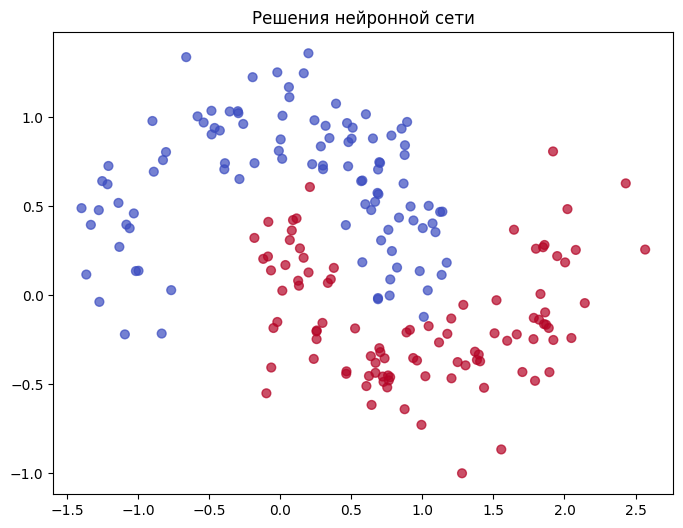

In [5]:
if __name__ == "__main__":
    X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    nn = NeuralNetwork(layer_dims=[2, 16, 8, 1], activation='relu', learning_rate=0.01)
    
    history = nn.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=True)
    
    y_pred = nn.predict(X_test)
    acc = np.mean(y_pred == y_test)
    print(f"Точность теста: {acc*100:.2f}%")
    
    plt.figure(figsize=(8,6))
    plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, cmap='coolwarm', alpha=0.7, s=40)
    plt.title("Решения нейронной сети")
    plt.show()